# Deep Learning Project 1

## Install Dependencies

In [20]:
!pip install -U torch torchvision matplotlib pandas torchsummary scikit-learn seaborn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/a8/f3/62fc9a5a659bb58a03cdd7e258956a5824bdc9b4bb3c5d932f55880be569/scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/32/ea/564bacc26b676c06a00266a3f25fdfe91a9d9a2532ccea7ce6dd394541bc/scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafca

## Define Custom ResNet Model: V2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, initial_channels=64, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = initial_channels

        self.conv1 = nn.Conv2d(3, initial_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(initial_channels)
        self.layer1 = self._make_layer(block, initial_channels, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, initial_channels * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, initial_channels * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, initial_channels * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(initial_channels * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNetCustom():
    # 2 residual blocks in layers 1 to 3, 1 block in layer 4
    # 56 initial channels, gets multiplied by powers of 2 for each subsequent residual layer
    return ResNet(BasicBlock, [2, 2, 2, 1], initial_channels=56)


## Get Num of Params

In [22]:
import torchsummary

torchsummary.summary(ResNetCustom().to('cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 56, 32, 32]           1,512
       BatchNorm2d-2           [-1, 56, 32, 32]             112
            Conv2d-3           [-1, 56, 32, 32]          28,224
       BatchNorm2d-4           [-1, 56, 32, 32]             112
            Conv2d-5           [-1, 56, 32, 32]          28,224
       BatchNorm2d-6           [-1, 56, 32, 32]             112
        BasicBlock-7           [-1, 56, 32, 32]               0
            Conv2d-8           [-1, 56, 32, 32]          28,224
       BatchNorm2d-9           [-1, 56, 32, 32]             112
           Conv2d-10           [-1, 56, 32, 32]          28,224
      BatchNorm2d-11           [-1, 56, 32, 32]             112
       BasicBlock-12           [-1, 56, 32, 32]               0
           Conv2d-13          [-1, 112, 16, 16]          56,448
      BatchNorm2d-14          [-1, 112,

## Train

In [ ]:
# validate on unseen data during training
def validate(net, dataloader, device):
    net.eval()
    total_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    net.train()
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return (avg_loss, accuracy)


def train(num_epochs=250):
    hist = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNetCustom().to(device)
    
    # SGD optimizer with L2 regularization and momentum
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1,
                                momentum=0.9, weight_decay=5e-4)
    # we start with a large LR and gradually decrease it with cosine annealing
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    # we use cross-entropy loss with label smoothing to prevent overfitting
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # we use data augmentation to prevent overfitting
    # we also normalize to improve model performance
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    train_size = int(0.9 * len(cifar_trainset))  # 90% for training, 10% for validation
    val_size = len(cifar_trainset) - train_size
    trainset, valset = torch.utils.data.random_split(cifar_trainset, [train_size, val_size])
    
    # we use a batch size of 512
    trainloader = DataLoader(trainset, batch_size=512, shuffle=True)
    valloader = DataLoader(valset, batch_size=512, shuffle=False)

    net.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100. * correct / total
        train_loss = running_loss/len(trainloader)
        val_loss, val_acc = validate(net, valloader, device)
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Train Loss = {train_loss:.4f}, Val Acc = {val_acc:.2f}% Val Loss = {val_loss:.4f}")
        hist.append({
            "epoch": epoch+1,
            "train_acc": train_acc,
            "train_loss": train_loss,
            "val_acc": val_acc,
            "val_loss": val_loss,
            "lr": scheduler.get_last_lr()[0]
        })
        scheduler.step()
    torch.save(net.state_dict(), 'manas.pth')
    return hist

train()


Epoch 1: Train Acc = 39.14%, Train Loss = 1.7987, Val Acc = 48.64% Val Loss = 1.4323
Epoch 2: Train Acc = 55.69%, Train Loss = 1.4685, Val Acc = 45.14% Val Loss = 1.5665
Epoch 3: Train Acc = 64.23%, Train Loss = 1.3013, Val Acc = 60.44% Val Loss = 1.1721
Epoch 4: Train Acc = 69.53%, Train Loss = 1.1878, Val Acc = 64.02% Val Loss = 1.0669
Epoch 5: Train Acc = 73.13%, Train Loss = 1.1139, Val Acc = 68.94% Val Loss = 0.9574
Epoch 6: Train Acc = 76.33%, Train Loss = 1.0441, Val Acc = 65.16% Val Loss = 1.0290
Epoch 7: Train Acc = 78.05%, Train Loss = 1.0050, Val Acc = 66.34% Val Loss = 0.9832
Epoch 8: Train Acc = 80.21%, Train Loss = 0.9632, Val Acc = 76.00% Val Loss = 0.7401
Epoch 9: Train Acc = 81.33%, Train Loss = 0.9353, Val Acc = 77.40% Val Loss = 0.7118
Epoch 10: Train Acc = 82.66%, Train Loss = 0.9052, Val Acc = 75.04% Val Loss = 0.7849
Epoch 11: Train Acc = 83.71%, Train Loss = 0.8847, Val Acc = 80.98% Val Loss = 0.6087
Epoch 12: Train Acc = 84.38%, Train Loss = 0.8658, Val Acc = 74

[{'epoch': 1,
  'train_acc': 39.135555555555555,
  'train_loss': 1.798688055439429,
  'val_acc': 48.64,
  'val_loss': 1.4322895526885986,
  'lr': 0.1},
 {'epoch': 2,
  'train_acc': 55.68888888888889,
  'train_loss': 1.468486643650315,
  'val_acc': 45.14,
  'val_loss': 1.5665191888809205,
  'lr': 0.09999605221019081},
 {'epoch': 3,
  'train_acc': 64.23333333333333,
  'train_loss': 1.3013217774304477,
  'val_acc': 60.44,
  'val_loss': 1.1721128821372986,
  'lr': 0.09998420946416499},
 {'epoch': 4,
  'train_acc': 69.53111111111112,
  'train_loss': 1.1877595592628827,
  'val_acc': 64.02,
  'val_loss': 1.066941899061203,
  'lr': 0.09996447363202945},
 {'epoch': 5,
  'train_acc': 73.13111111111111,
  'train_loss': 1.1138897050510754,
  'val_acc': 68.94,
  'val_loss': 0.9573816657066345,
  'lr': 0.09993684783030087},
 {'epoch': 6,
  'train_acc': 76.32666666666667,
  'train_loss': 1.0441364463080058,
  'val_acc': 65.16,
  'val_loss': 1.0290025770664215,
  'lr': 0.09990133642141356},
 {'epoch':

## Test

### Test on CIFAR-10 Test Dataset

Test Accuracy: 94.07%


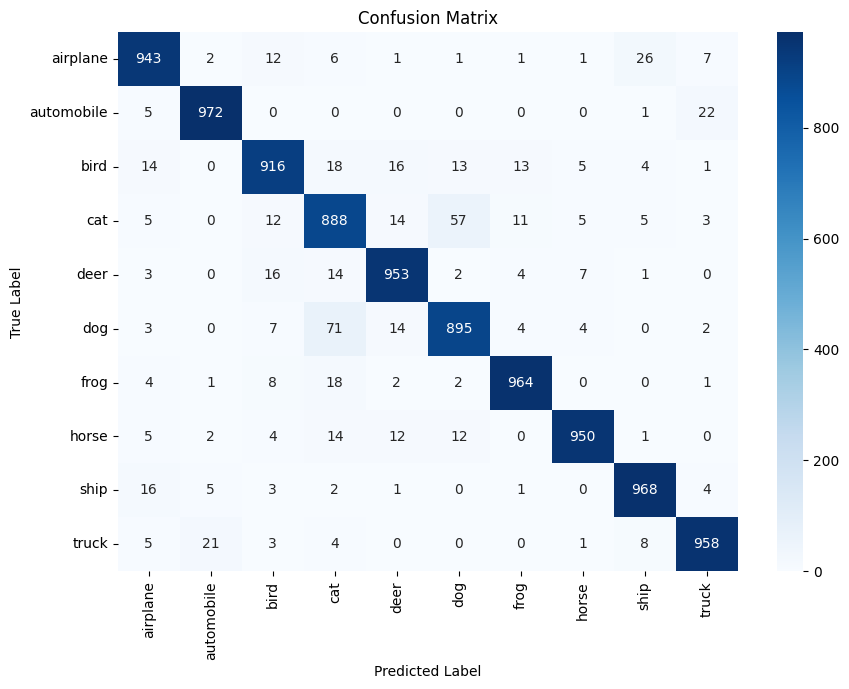

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNetCustom().to(device)
    net.load_state_dict(torch.load('manas.pth'))
    net.eval()
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=512, shuffle=False)
    
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(f'Test Accuracy: {100 * correct / total}%')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    classes = testset.classes  # CIFAR-10 class names
    plot_confusion_matrix(cm, classes)


test()

### Plot Training History

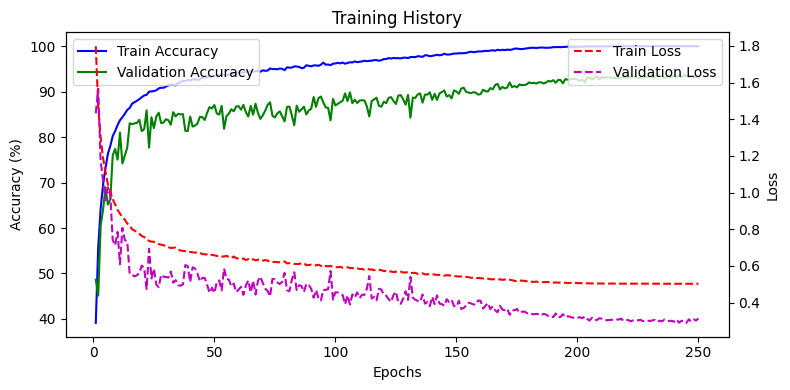

In [ ]:
import json
import matplotlib.pyplot as plt


def plot_history(hist):
    epochs = [epoch["epoch"] for epoch in hist]
    train_acc = [epoch["train_acc"] for epoch in hist]
    val_acc = [epoch["val_acc"] for epoch in hist]
    train_loss = [epoch["train_loss"] for epoch in hist]
    val_loss = [epoch["val_loss"] for epoch in hist]
    
    _, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()
    
    ax1.plot(epochs, train_acc, 'b-', label="Train Accuracy")
    ax1.plot(epochs, val_acc, 'g-', label="Validation Accuracy")
    ax2.plot(epochs, train_loss, 'r--', label="Train Loss")
    ax2.plot(epochs, val_loss, 'm--', label="Validation Loss")
    
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy (%)")
    ax2.set_ylabel("Loss")
    
    # Remove color settings for ticks and labels
    ax1.tick_params(axis='y')
    ax2.tick_params(axis='y')
    
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.title("Training History")
    plt.tight_layout()
    plt.show()

# forgot to save so had to copy and paste
with open("final_hist.txt", 'r') as f:
    text = f.read()
    text = text.replace("'", "\"")
    hist = json.loads(text)
    plot_history(hist)

### Plot Training Learning Rate

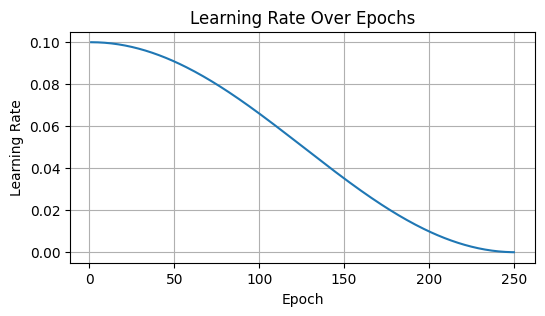

In [ ]:
import json
import matplotlib.pyplot as plt

def plot_lr(hist):
    epochs = [epoch["epoch"] for epoch in hist]
    lrs = [epoch["lr"] for epoch in hist]
    
    plt.figure(figsize=(6, 3))
    plt.plot(epochs, lrs)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Over Epochs")
    plt.grid()
    plt.show()
    
with open("final_hist.txt", 'r') as f:
    text = f.read()
    text = text.replace("'", "\"")
    hist = json.loads(text)
    plot_lr(hist)


## Evaluation on Kaggle Dataset

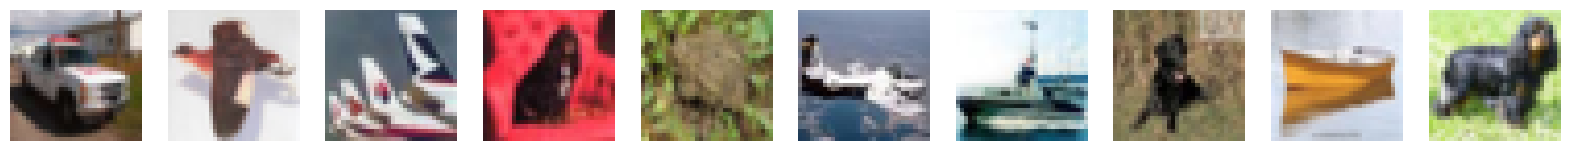

In [ ]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import random as rand
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
import pickle

classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

def unpickle(file):
    """ read pickle file """
    with open(file, 'rb') as fo:
        datadict = pickle.load(fo, encoding='bytes')
    return datadict

def load_eval(filename):
    """ load eval batch """
    datadict = unpickle(filename)
    ids = datadict[b'ids']
    imgs = datadict[b'data']
    imgs = imgs.astype("uint8")
    return ids, imgs

# Create a custom dataset class
class EvalDataset(Dataset):
    def __init__(self, ids, images, transform=None):
        self.ids = ids
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        id = self.ids[idx]
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return id, img

ids, imgs = load_eval('cifar_test_nolabel.pkl')

# Visualize a few images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    idx = rand.randint(0, len(imgs))
    axes[i].imshow(imgs[idx])
    axes[i].axis("off")
plt.show()

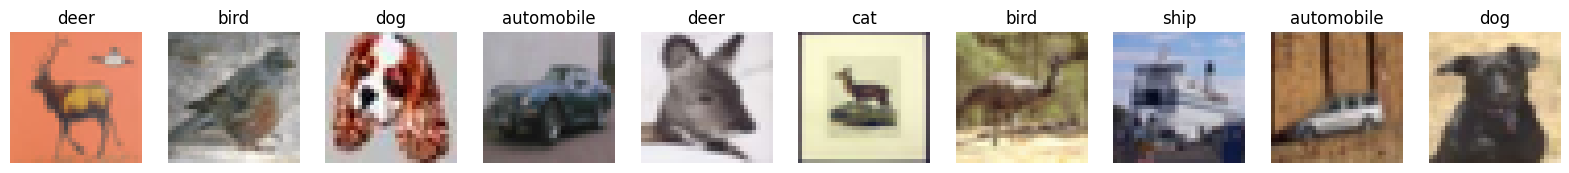

In [ ]:
def evaluate(dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNetCustom().to(device)
    # Load the trained model
    net.load_state_dict(torch.load('manas.pth'))
    net.eval()
    with torch.no_grad():
        for ids, inputs in dataloader:
            inputs = inputs.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred = predicted.data.cpu().numpy()
            df = pd.DataFrame({'ID': ids.numpy(), 'Labels': y_pred})
            df.to_csv('submission.csv', index=False)

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
eval_dataset = EvalDataset(ids, imgs, transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=10000, shuffle=False)
evaluate(eval_dataloader)

# Visualize a few labeled images
df = pd.read_csv('submission.csv')
df_elements = df.sample(n=10)
df_elements['Labels'] = df_elements['Labels'].map(lambda x: classes[x])
df_elements = df_elements.to_numpy()

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(imgs[df_elements[i][0]])
    axes[i].set_title(df_elements[i][1])
    axes[i].axis("off")